In [15]:
import pandas as pd, numpy as np
import os, time, random,gc
from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
os.listdir('input')

['.ipynb_checkpoints',
 'new_te.feather',
 'new_te_abl.feather',
 'new_te_cam.feather',
 'new_te_cam_ts.feather',
 'new_te_eve_ts.feather',
 'new_te_rc.feather',
 'new_te_rc_ts.feather',
 'new_tr.feather',
 'new_tr_abl.feather',
 'new_tr_cam.feather',
 'new_tr_cam_ts.feather',
 'new_tr_eve_ts.feather',
 'new_tr_rc.feather',
 'new_tr_rc_ts.feather',
 'sample_submission.csv',
 'te.feather',
 'test.csv',
 'te_abl.feather',
 'te_cam.feather',
 'te_rc.feather',
 'te_time_eve.feather',
 'te_tsact_sp.feather',
 'te_v7.feather',
 'tr.feather',
 'train.csv',
 'tr_abl.feather',
 'tr_rc.feather',
 'tr_time_eve.feather',
 'tr_tsact_sp.feather',
 'tr_v7.feather']

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

In [4]:
%%time
tr = pd.read_feather('../dacon_sc/input/tr.feather')
te = pd.read_feather('../dacon_sc/input/te.feather')

Wall time: 33.2 s


In [5]:
tr.head()

,game_id,winner,time,player,species,event,event_contents
0,0,1,0.00,0,T,Camera,"at (145.25, 21.5078125)"
1,0,1,0.00,1,T,Camera,"at (22.75, 147.0078125)"
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]']
3,0,1,0.02,0,T,Ability,(1360) - TrainSCV
4,0,1,0.14,0,T,Camera,"at (142.99609375, 24.50390625)"


In [64]:
tr_y = tr.groupby(['game_id'])['winner'].max()
tr_y = tr_y.reset_index()
train_Y = tr_y['winner']
tr_y.head()

,game_id,winner
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0


In [7]:
tr.shape

(67091776, 7)

In [36]:
tr.head()

,game_id,winner,time,player,species,event,event_contents,time_span
0,0,1,0.00,0,T,Camera,"at (145.25, 21.5078125)",0
1,0,1,0.00,1,T,Camera,"at (22.75, 147.0078125)",0
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]'],0
3,0,1,0.02,0,T,Ability,(1360) - TrainSCV,0
4,0,1,0.14,0,T,Camera,"at (142.99609375, 24.50390625)",0


In [8]:
def make_timespan(df):
    df['time_span'] = 0
    df['time_span'] = np.where(df['time']<1, 0, 
                                  np.where(df['time']<2, 1, 
                                          np.where(df['time']<3, 2,
                                                  np.where(df['time']<4, 3,
                                                          np.where(df['time']<5, 4,
                                                                  np.where(df['time']<6, 5,
                                                                          np.where(df['time']<7, 6,
                                                                                  np.where(df['time']<8, 7,
                                                                                          np.where(df['time']<9, 8,
                                                                                                   np.where(df['time']<10, 9, 10))))))))))
    return df

In [57]:
def tsp_cnt(df):
    df = make_timespan(df)
    new_p0 = pd.DataFrame({"game_id":df['game_id'].unique()})
    p0 = df[df['player']==0]
    for tsp in tqdm(range(11)):    
        tmp = p0[p0['time_span']==tsp].groupby(['game_id'])['time'].count().reset_index().rename(columns={"time":"p0_tsp_{}_cnt".format(tsp)})
    #     tmp.drop(['time_span'],axis=1, inplace=True)
        new_p0 = new_p0.merge(tmp, on='game_id', how='left')
    
    new_p1 = pd.DataFrame({"game_id":df['game_id'].unique()})
    p1 = df[df['player']==1]
    for tsp in tqdm(range(11)):    
        tmp = p1[p1['time_span']==tsp].groupby(['game_id'])['time'].count().reset_index().rename(columns={"time":"p1_tsp_{}_cnt".format(tsp)})
    #     tmp.drop(['time_span'],axis=1, inplace=True)
        new_p1 = new_p1.merge(tmp, on='game_id', how='left')
    
    new_df = new_p0.merge(new_p1, on='game_id', how='left')
    return new_df

In [53]:
tr_tsp = tsp_cnt(tr)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.32it/s]


In [58]:
te_tsp = tsp_cnt(te)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.55it/s]


In [54]:
tr_tsp.head()

,game_id,p0_tsp_0_cnt,p0_tsp_1_cnt,p0_tsp_2_cnt,p0_tsp_3_cnt,p0_tsp_4_cnt,p0_tsp_5_cnt,p0_tsp_6_cnt,p0_tsp_7_cnt,p0_tsp_8_cnt,...,p1_tsp_1_cnt,p1_tsp_2_cnt,p1_tsp_3_cnt,p1_tsp_4_cnt,p1_tsp_5_cnt,p1_tsp_6_cnt,p1_tsp_7_cnt,p1_tsp_8_cnt,p1_tsp_9_cnt,p1_tsp_10_cnt
0,0,55.0,60.0,84.0,96.0,88.0,77.0,92.0,40.0,NaN,...,31.0,65.0,120.0,130.0,85.0,54.0,31.0,NaN,NaN,NaN
1,1,77.0,161.0,183.0,88.0,110.0,109.0,96.0,121.0,146.0,...,62.0,128.0,101.0,137.0,132.0,128.0,144.0,118.0,151.0,NaN
2,2,123.0,69.0,66.0,66.0,103.0,62.0,75.0,78.0,129.0,...,90.0,100.0,131.0,151.0,132.0,137.0,169.0,181.0,179.0,NaN
3,3,112.0,120.0,123.0,142.0,135.0,172.0,113.0,167.0,117.0,...,221.0,163.0,161.0,190.0,155.0,134.0,160.0,134.0,148.0,NaN
4,4,66.0,192.0,216.0,193.0,155.0,144.0,NaN,NaN,NaN,...,109.0,119.0,105.0,111.0,64.0,NaN,NaN,NaN,NaN,NaN


In [59]:
te_tsp.head()

,game_id,p0_tsp_0_cnt,p0_tsp_1_cnt,p0_tsp_2_cnt,p0_tsp_3_cnt,p0_tsp_4_cnt,p0_tsp_5_cnt,p0_tsp_6_cnt,p0_tsp_7_cnt,p0_tsp_8_cnt,...,p1_tsp_1_cnt,p1_tsp_2_cnt,p1_tsp_3_cnt,p1_tsp_4_cnt,p1_tsp_5_cnt,p1_tsp_6_cnt,p1_tsp_7_cnt,p1_tsp_8_cnt,p1_tsp_9_cnt,p1_tsp_10_cnt
0,38872,39.0,28.0,86.0,93.0,93.0,107.0,102.0,23.0,NaN,...,57.0,114.0,156.0,109.0,64.0,120.0,17.0,NaN,NaN,NaN
1,38873,62.0,34.0,40.0,92.0,95.0,86.0,12.0,NaN,NaN,...,102.0,61.0,30.0,59.0,58.0,2.0,NaN,NaN,NaN,NaN
2,38874,90.0,118.0,104.0,89.0,68.0,NaN,NaN,NaN,NaN,...,227.0,156.0,151.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN
3,38875,109.0,187.0,191.0,145.0,170.0,143.0,158.0,120.0,NaN,...,111.0,107.0,125.0,133.0,90.0,134.0,86.0,NaN,NaN,NaN
4,38876,242.0,209.0,131.0,NaN,NaN,NaN,NaN,NaN,NaN,...,92.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
def get_sp(df):

    df_tmp = pd.DataFrame(df.game_id.unique(), columns=['game_id'])
    df_tmp.index = df_tmp.game_id
    df_tmp = df_tmp.drop(['game_id'], axis = 1)
    
    p0 = df[(df.event=='Camera')&(df.player==0)]
    p0 = p0[p0.shift(1).game_id!=p0.game_id] # 쉬프트를 이용하여 각 게임의 첫번째 데이터 찾기
    p0 = p0.loc[:, ['game_id','event_contents']].rename({'event_contents':'player0_starting'}, axis = 1)
    p0.index = p0['game_id']
    p0 = p0.drop(['game_id'], axis=1)
    df_tmp = pd.merge(df_tmp, p0, on='game_id', how='left')
    del p0
    p1 = df[(df.event=='Camera')&(df.player==1)]
    p1 = p1[p1.shift(1).game_id!=p1.game_id]
    p1 = p1.loc[:, ['game_id','event_contents']].rename({'event_contents':'player1_starting'}, axis = 1)
    p1.index = p1['game_id']
    p1 = p1.drop(['game_id'], axis=1)
    df_tmp = pd.merge(df_tmp, p1, on='game_id', how='left')
    del p1
    
    df_tmp['player0_starting'] = df_tmp.player0_starting.str.split('(').str[1]
    df_tmp['player0_starting'] = df_tmp.player0_starting.str.split(')').str[0]
    split_xy = df_tmp.player0_starting.str.split(',')
    df_tmp['player0_x'] = split_xy.str[0].astype('float')
    df_tmp['player0_y'] = split_xy.str[1].astype('float')
    del split_xy

    df_tmp['player1_starting'] = df_tmp.player1_starting.str.split('(').str[1]
    df_tmp['player1_starting'] = df_tmp.player1_starting.str.split(')').str[0]
    split_xy = df_tmp.player1_starting.str.split(',')
    df_tmp['player1_x'] = split_xy.str[0].astype('float')
    df_tmp['player1_y'] = split_xy.str[1].astype('float')
    del split_xy
    
#     location_p0 = df_tmp.loc[:, ['player0_x', 'player0_y']]
#     location_p0 = location_p0.rename({'player0_x':'location_x', 'player0_y':'location_y'}, axis=1)

#     location_p1 = df_tmp.loc[:, ['player1_x', 'player1_y']]
#     location_p1 = location_p1.rename({'player1_x':'location_x', 'player1_y':'location_y'}, axis=1)
#     location_p1.index += location_p0.index[-1]+1
    
#     location = pd.concat([location_p0, location_p1])
#     location = location.dropna()
#     del location_p0, location_p1, df_tmp

    df_tmp.fillna(-999, inplace=True)
    df_tmp['p0_sp'] = df_tmp['player0_x'].astype(int).astype(str) + df_tmp['player0_y'].astype(int).astype(str)
    df_tmp['p1_sp'] = df_tmp['player1_x'].astype(int).astype(str) + df_tmp['player1_y'].astype(int).astype(str)
    df_tmp['p0_sp2'] = np.round(df_tmp['player0_x'],2).astype(str) + np.round(df_tmp['player0_y'],2).astype(str)
    df_tmp['p1_sp2'] = np.round(df_tmp['player1_x'],2).astype(str) + np.round(df_tmp['player1_y'],2).astype(str)
    
    df_tmp['all_sp'] = df_tmp['p0_sp']+df_tmp['p1_sp']
    df_tmp['all_sp2'] = df_tmp['p0_sp2']+df_tmp['p1_sp2']
    
    return df_tmp

In [98]:
%%time
tr_sp = get_sp(tr)
te_sp = get_sp(te)

Wall time: 24.4 s


In [99]:
tr_sp.head()

,player0_starting,player1_starting,player0_x,player0_y,player1_x,player1_y,p0_sp,p1_sp,p0_sp2,p1_sp2,all_sp,all_sp2
game_id,,,,,,,,,,,,
0,"145.25, 21.5078125","22.75, 147.0078125",145.25,21.507812,22.75,147.007812,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01
1,"140.0, 162.0078125","28.0, 18.5078125",140.00,162.007812,28.00,18.507812,140162,2818,140.0162.01,28.018.51,1401622818,140.0162.0128.018.51
2,"151.25, 20.5078125","24.75, 128.0078125",151.25,20.507812,24.75,128.007812,15120,24128,151.2520.51,24.75128.01,1512024128,151.2520.5124.75128.01
3,"127.25, 27.5078125","24.75, 137.0078125",127.25,27.507812,24.75,137.007812,12727,24137,127.2527.51,24.75137.01,1272724137,127.2527.5124.75137.01
4,"36.75, 122.0078125","163.25, 18.5078125",36.75,122.007812,163.25,18.507812,36122,16318,36.75122.01,163.2518.51,3612216318,36.75122.01163.2518.51


In [100]:
te_sp.head()

,player0_starting,player1_starting,player0_x,player0_y,player1_x,player1_y,p0_sp,p1_sp,p0_sp2,p1_sp2,all_sp,all_sp2
game_id,,,,,,,,,,,,
38872,"22.25, 81.5078125","120.25, 153.83984375",22.25,81.507812,120.25,153.839844,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
38873,"24.75, 128.0078125","151.25, 20.5078125",24.75,128.007812,151.25,20.507812,24128,15120,24.75128.01,151.2520.51,2412815120,24.75128.01151.2520.51
38874,"151.25, 20.5078125","24.75, 128.0078125",151.25,20.507812,24.75,128.007812,15120,24128,151.2520.51,24.75128.01,1512024128,151.2520.5124.75128.01
38875,"152.25, 142.0078125","31.75, 22.5078125",152.25,142.007812,31.75,22.507812,152142,3122,152.25142.01,31.7522.51,1521423122,152.25142.0131.7522.51
38876,"135.25, 31.5078125","22.25, 81.5078125",135.25,31.507812,22.25,81.507812,13531,2281,135.2531.51,22.2581.51,135312281,135.2531.5122.2581.51


In [102]:
tr_sp.nunique()

player0_starting     972
player1_starting     976
player0_x            406
player0_y            716
player1_x            440
player1_y            715
p0_sp                368
p1_sp                379
p0_sp2               928
p1_sp2               937
all_sp               802
all_sp2             1880
dtype: int64

In [103]:
te_sp.nunique()

player0_starting    441
player1_starting    471
player0_x           194
player0_y           323
player1_x           186
player1_y           371
p0_sp               208
p1_sp               223
p0_sp2              414
p1_sp2              441
all_sp              439
all_sp2             862
dtype: int64

In [104]:
tra = tr.merge(tr_sp.iloc[:,-6:], on='game_id', how='left')
tra.head()

,game_id,winner,time,player,species,event,event_contents,time_span,p0_sp,p1_sp,p0_sp2,p1_sp2,all_sp,all_sp2
0,0,1,0.00,0,T,Camera,"at (145.25, 21.5078125)",0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01
1,0,1,0.00,1,T,Camera,"at (22.75, 147.0078125)",0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]'],0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01
3,0,1,0.02,0,T,Ability,(1360) - TrainSCV,0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01
4,0,1,0.14,0,T,Camera,"at (142.99609375, 24.50390625)",0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01


In [327]:
trp0 = tr[tr['player']==0].groupby(['game_id','time_span'])['time'].count().reset_index().rename(columns={"time":"p0_cnt"})
trp1 = tr[tr['player']==1].groupby(['game_id','time_span'])['time'].count().reset_index().rename(columns={"time":"p1_cnt"})

trcnt = trp0.merge(trp1, on=['game_id','time_span'], how='left')
trcnt = trcnt.merge(tr_sp.iloc[:,-6:], on='game_id', how='left')

In [328]:
tep0 = te[te['player']==0].groupby(['game_id','time_span'])['time'].count().reset_index().rename(columns={"time":"p0_cnt"})
tep1 = te[te['player']==1].groupby(['game_id','time_span'])['time'].count().reset_index().rename(columns={"time":"p1_cnt"})

tecnt = tep0.merge(tep1, on=['game_id','time_span'], how='left')
tecnt = tecnt.merge(te_sp.iloc[:,-6:], on='game_id', how='left')

In [329]:
tecnt.head(20)

,game_id,time_span,p0_cnt,p1_cnt,p0_sp,p1_sp,p0_sp2,p1_sp2,all_sp,all_sp2
0,38872,0,39,78.0,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
1,38872,1,28,57.0,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
2,38872,2,86,114.0,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
3,38872,3,93,156.0,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
4,38872,4,93,109.0,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
5,38872,5,107,64.0,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
6,38872,6,102,120.0,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
7,38872,7,23,17.0,2281,120153,22.2581.51,120.25153.84,2281120153,22.2581.51120.25153.84
8,38873,0,62,77.0,24128,15120,24.75128.01,151.2520.51,2412815120,24.75128.01151.2520.51
9,38873,1,34,102.0,24128,15120,24.75128.01,151.2520.51,2412815120,24.75128.01151.2520.51


In [330]:
def get_spc(df):
    p0_spc = df[df['player']==0].groupby(['game_id'])['species'].max().reset_index().rename(columns={"species":'p0_spc'})
    p1_spc = df[df['player']==1].groupby(['game_id'])['species'].max().reset_index().rename(columns={"species":'p1_spc'})
    p0_spc = p0_spc.merge(p1_spc, on='game_id', how='left')
    return p0_spc

In [331]:
%%time
tr_spc = get_spc(tr)
te_spc = get_spc(te)

Wall time: 24.9 s


In [332]:
tr_spc.head()

,game_id,p0_spc,p1_spc
0,0,T,T
1,1,P,T
2,2,P,Z
3,3,T,P
4,4,T,Z


In [333]:
trcnt = trcnt.merge(tr_spc, on='game_id', how='left')
tecnt = tecnt.merge(te_spc, on='game_id', how='left')

In [337]:
trcnt['game_spc'] = trcnt['p0_spc']+trcnt['p1_spc']
tecnt['game_spc'] = tecnt['p0_spc']+tecnt['p1_spc']

trcnt['game_allsp_spc'] = trcnt['all_sp']+trcnt['p0_spc']+trcnt['p1_spc']
trcnt['game_allsp2_spc'] = trcnt['all_sp2']+trcnt['p0_spc']+trcnt['p1_spc']

tecnt['game_allsp_spc'] = tecnt['all_sp']+tecnt['p0_spc']+tecnt['p1_spc']
tecnt['game_allsp2_spc'] = tecnt['all_sp2']+tecnt['p0_spc']+tecnt['p1_spc']

trcnt['game_spc_sort'] = trcnt['game_spc'].apply(lambda x: sorted(x))
tecnt['game_spc_sort'] = tecnt['game_spc'].apply(lambda x: sorted(x))

In [338]:
trcnt.head()

,game_id,time_span,p0_cnt,p1_cnt,p0_sp,p1_sp,p0_sp2,p1_sp2,all_sp,all_sp2,p0_spc,p1_spc,game_spc,game_allsp_spc,game_spc_sort,game_allsp2_spc
0,0,0,55,32.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,T,T,TT,1452122147TT,"[T, T]",145.2521.5122.75147.01TT
1,0,1,60,31.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,T,T,TT,1452122147TT,"[T, T]",145.2521.5122.75147.01TT
2,0,2,84,65.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,T,T,TT,1452122147TT,"[T, T]",145.2521.5122.75147.01TT
3,0,3,96,120.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,T,T,TT,1452122147TT,"[T, T]",145.2521.5122.75147.01TT
4,0,4,88,130.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,T,T,TT,1452122147TT,"[T, T]",145.2521.5122.75147.01TT


In [339]:
tecnt.tail()

,game_id,time_span,p0_cnt,p1_cnt,p0_sp,p1_sp,p0_sp2,p1_sp2,all_sp,all_sp2,p0_spc,p1_spc,game_spc,game_allsp2_spc,game_spc_sort,game_allsp_spc
132212,55658,0,32,72.0,36122,16318,36.75122.01,163.2518.51,3612216318,36.75122.01163.2518.51,Z,T,ZT,36.75122.01163.2518.51ZT,"[T, Z]",3612216318ZT
132213,55658,1,16,88.0,36122,16318,36.75122.01,163.2518.51,3612216318,36.75122.01163.2518.51,Z,T,ZT,36.75122.01163.2518.51ZT,"[T, Z]",3612216318ZT
132214,55658,2,26,97.0,36122,16318,36.75122.01,163.2518.51,3612216318,36.75122.01163.2518.51,Z,T,ZT,36.75122.01163.2518.51ZT,"[T, Z]",3612216318ZT
132215,55658,3,52,97.0,36122,16318,36.75122.01,163.2518.51,3612216318,36.75122.01163.2518.51,Z,T,ZT,36.75122.01163.2518.51ZT,"[T, Z]",3612216318ZT
132216,55658,4,63,140.0,36122,16318,36.75122.01,163.2518.51,3612216318,36.75122.01163.2518.51,Z,T,ZT,36.75122.01163.2518.51ZT,"[T, Z]",3612216318ZT


In [340]:
trcnt.shape,tecnt.shape

((307284, 16), (132217, 16))

In [116]:
def df_copy(tr_df, te_df):
    tr = tr_df.copy();te = te_df.copy()
    return tr, te

def sub_day_agg(tr_df, te_df, merge_columns, date_columns, columns, aggs=['mean']):
    tr, te = df_copy(tr_df, te_df)
    for merge_column in merge_columns:
        for date in date_columns:
            tr['mc_date'] = tr[merge_column].astype(str) + '_' +tr[date].astype(str)
            te['mc_date'] = te[merge_column].astype(str) + '_' +te[date].astype(str)
            for col in columns:
                for agg in aggs:
                    valid = pd.concat([tr[['mc_date', col]], te[['mc_date', col]]])
                    new_cn = merge_column + '_' + date + '_' + col + '_' + agg
                    if agg=='quantile':
                        valid = valid.groupby('mc_date')[col].quantile(0.8).reset_index().rename(columns={col:new_cn})
                    else:
                        valid = valid.groupby('mc_date')[col].agg([agg]).reset_index().rename(columns={agg:new_cn})
                    valid.index = valid['mc_date'].tolist()
                    valid = valid[new_cn].to_dict()
                
                    tr[new_cn] = tr['mc_date'].map(valid)
                    te[new_cn] = te['mc_date'].map(valid)
    tr = tr.drop(columns=['mc_date'])
    te = te.drop(columns=['mc_date'])
    return tr, te

In [341]:
traa, teaa = sub_day_agg(trcnt, tecnt, merge_columns=['all_sp','all_sp2','p0_spc','p1_spc','game_allsp_spc','game_spc_sort','game_allsp2_spc'], 
                         date_columns=['time_span'], columns=['p0_cnt', 'p1_cnt'], aggs=['mean'])

In [342]:
traa.head()

,game_id,time_span,p0_cnt,p1_cnt,p0_sp,p1_sp,p0_sp2,p1_sp2,all_sp,all_sp2,...,p0_spc_time_span_p0_cnt_mean,p0_spc_time_span_p1_cnt_mean,p1_spc_time_span_p0_cnt_mean,p1_spc_time_span_p1_cnt_mean,game_allsp_spc_time_span_p0_cnt_mean,game_allsp_spc_time_span_p1_cnt_mean,game_spc_sort_time_span_p0_cnt_mean,game_spc_sort_time_span_p1_cnt_mean,game_allsp2_spc_time_span_p0_cnt_mean,game_allsp2_spc_time_span_p1_cnt_mean
0,0,0,55,32.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,...,98.912741,91.921979,92.321525,98.673354,103.508914,101.987034,97.249723,97.324923,103.996610,102.423729
1,0,1,60,31.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,...,110.627646,98.452991,99.160792,110.410803,116.042623,114.829508,108.629398,109.165935,116.398973,115.037671
2,0,2,84,65.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,...,114.888448,105.936428,106.210303,114.898538,119.657763,119.228715,112.164698,112.655940,120.111498,119.550523
3,0,3,96,120.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,...,120.763982,112.282863,112.731695,120.912524,121.144852,122.253054,117.436267,117.672322,121.258652,122.672131
4,0,4,88,130.0,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,...,120.419539,115.464194,116.005994,120.716896,121.725681,122.416342,117.950541,118.662612,121.725610,122.662602


In [343]:
def sub_day_agg_flat(df):
    new_df = pd.DataFrame({"game_id":df['game_id'].unique()})
    for tsp in tqdm(range(11)):
        tmp = df[df['time_span']==tsp][['game_id','all_sp_time_span_p0_cnt_mean'
                                        ,'all_sp_time_span_p1_cnt_mean'
                                        ,'all_sp2_time_span_p0_cnt_mean'
                                        ,'all_sp2_time_span_p1_cnt_mean'
                                       ,'p0_spc_time_span_p0_cnt_mean'
                                        ,'p0_spc_time_span_p1_cnt_mean'
                                       ,'p1_spc_time_span_p0_cnt_mean'
                                        ,'p1_spc_time_span_p1_cnt_mean'
                                        ,'game_allsp_spc_time_span_p0_cnt_mean'
                                        ,'game_allsp_spc_time_span_p1_cnt_mean'
                                        ,'game_spc_sort_time_span_p0_cnt_mean'
                                        ,'game_spc_sort_time_span_p1_cnt_mean'
                                        ,'game_allsp2_spc_time_span_p0_cnt_mean'
                                        ,'game_allsp2_spc_time_span_p1_cnt_mean'
                                       ]]
        
        tmp.rename(columns={"all_sp_time_span_p0_cnt_mean":"all_sp_time_span_p0_cnt_mean_t{}".format(tsp)
                            ,"all_sp_time_span_p1_cnt_mean":"all_sp_time_span_p1_cnt_mean_t{}".format(tsp)
                           ,"all_sp2_time_span_p0_cnt_mean":"all_sp2_time_span_p0_cnt_mean_t{}".format(tsp)
                            ,"all_sp2_time_span_p1_cnt_mean":"all_sp2_time_span_p1_cnt_mean_t{}".format(tsp)
                            
                            ,"p0_spc_time_span_p0_cnt_mean":"p0_spc_time_span_p0_cnt_mean_t{}".format(tsp)
                            ,"p0_spc_time_span_p1_cnt_mean":"p0_spc_time_span_p1_cnt_mean_t{}".format(tsp)
                           ,"p1_spc_time_span_p0_cnt_mean":"p1_spc_time_span_p0_cnt_mean_t{}".format(tsp)
                            ,"p1_spc_time_span_p1_cnt_mean":"p1_spc_time_span_p1_cnt_mean_t{}".format(tsp)
                            
                            ,"game_allsp_spc_time_span_p0_cnt_mean":"game_allsp_spc_time_span_p0_cnt_mean_t{}".format(tsp)
                            ,"game_allsp_spc_time_span_p1_cnt_mean":"game_allsp_spc_time_span_p1_cnt_mean_t{}".format(tsp)
                            ,"game_spc_sort_time_span_p0_cnt_mean":"game_spc_sort_time_span_p0_cnt_mean_t{}".format(tsp)
                            ,"game_spc_sort_time_span_p1_cnt_mean":"game_spc_sort_time_span_p1_cnt_mean_t{}".format(tsp)
                            ,"game_allsp2_spc_time_span_p0_cnt_mean":"game_allsp2_spc_time_span_p0_cnt_mean_t{}".format(tsp)
                            ,"game_allsp2_spc_time_span_p1_cnt_mean":"game_allsp2_spc_time_span_p1_cnt_mean_t{}".format(tsp)
                           },inplace=True)
        new_df = new_df.merge(tmp, on='game_id', how='left')
    return new_df

In [344]:
tr_sub = sub_day_agg_flat(traa)
te_sub = sub_day_agg_flat(teaa)


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 25.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 54.44it/s]


In [345]:
tr_sub.head()

,game_id,all_sp_time_span_p0_cnt_mean_t0,all_sp_time_span_p1_cnt_mean_t0,all_sp2_time_span_p0_cnt_mean_t0,all_sp2_time_span_p1_cnt_mean_t0,p0_spc_time_span_p0_cnt_mean_t0,p0_spc_time_span_p1_cnt_mean_t0,p1_spc_time_span_p0_cnt_mean_t0,p1_spc_time_span_p1_cnt_mean_t0,game_allsp_spc_time_span_p0_cnt_mean_t0,...,p0_spc_time_span_p0_cnt_mean_t10,p0_spc_time_span_p1_cnt_mean_t10,p1_spc_time_span_p0_cnt_mean_t10,p1_spc_time_span_p1_cnt_mean_t10,game_allsp_spc_time_span_p0_cnt_mean_t10,game_allsp_spc_time_span_p1_cnt_mean_t10,game_spc_sort_time_span_p0_cnt_mean_t10,game_spc_sort_time_span_p1_cnt_mean_t10,game_allsp2_spc_time_span_p0_cnt_mean_t10,game_allsp2_spc_time_span_p1_cnt_mean_t10
0,0,97.949502,95.601550,97.920591,95.756233,98.912741,91.921979,92.321525,98.673354,103.508914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,95.553487,96.292849,95.787963,96.650309,84.523932,91.477730,92.321525,98.673354,83.965699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,93.741047,92.444718,93.832788,92.449790,84.523932,91.477730,98.460280,96.260913,96.605263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,92.869878,93.066791,93.034981,92.881732,98.912741,91.921979,91.695952,84.532361,92.447368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,93.434211,93.959978,93.522126,93.832471,98.912741,91.921979,98.460280,96.260913,99.761702,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [346]:
len(list(set(tr_sub.columns.tolist())))

155

In [347]:
te_sub.head()

,game_id,all_sp_time_span_p0_cnt_mean_t0,all_sp_time_span_p1_cnt_mean_t0,all_sp2_time_span_p0_cnt_mean_t0,all_sp2_time_span_p1_cnt_mean_t0,p0_spc_time_span_p0_cnt_mean_t0,p0_spc_time_span_p1_cnt_mean_t0,p1_spc_time_span_p0_cnt_mean_t0,p1_spc_time_span_p1_cnt_mean_t0,game_allsp_spc_time_span_p0_cnt_mean_t0,...,p0_spc_time_span_p0_cnt_mean_t10,p0_spc_time_span_p1_cnt_mean_t10,p1_spc_time_span_p0_cnt_mean_t10,p1_spc_time_span_p1_cnt_mean_t10,game_allsp_spc_time_span_p0_cnt_mean_t10,game_allsp_spc_time_span_p1_cnt_mean_t10,game_spc_sort_time_span_p0_cnt_mean_t10,game_spc_sort_time_span_p1_cnt_mean_t10,game_allsp2_spc_time_span_p0_cnt_mean_t10,game_allsp2_spc_time_span_p1_cnt_mean_t10
0,38872,87.886792,92.115427,88.257611,91.928571,84.523932,91.477730,91.695952,84.532361,73.720000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,38873,93.983195,93.347076,94.132257,93.538858,96.691914,98.319118,91.695952,84.532361,97.622871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38874,93.741047,92.444718,93.832788,92.449790,98.912741,91.921979,92.321525,98.673354,96.003236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38875,95.117647,95.953930,95.464043,96.148168,98.912741,91.921979,91.695952,84.532361,98.079903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38876,90.352159,90.729790,89.937572,90.447399,96.691914,98.319118,98.460280,96.260913,83.682692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
tr_tsp.head()

,game_id,p0_tsp_0_cnt,p0_tsp_1_cnt,p0_tsp_2_cnt,p0_tsp_3_cnt,p0_tsp_4_cnt,p0_tsp_5_cnt,p0_tsp_6_cnt,p0_tsp_7_cnt,p0_tsp_8_cnt,...,p1_tsp_1_cnt,p1_tsp_2_cnt,p1_tsp_3_cnt,p1_tsp_4_cnt,p1_tsp_5_cnt,p1_tsp_6_cnt,p1_tsp_7_cnt,p1_tsp_8_cnt,p1_tsp_9_cnt,p1_tsp_10_cnt
0,0,55.0,60.0,84.0,96.0,88.0,77.0,92.0,40.0,0.0,...,31.0,65.0,120.0,130.0,85.0,54.0,31.0,0.0,0.0,0.0
1,1,77.0,161.0,183.0,88.0,110.0,109.0,96.0,121.0,146.0,...,62.0,128.0,101.0,137.0,132.0,128.0,144.0,118.0,151.0,0.0
2,2,123.0,69.0,66.0,66.0,103.0,62.0,75.0,78.0,129.0,...,90.0,100.0,131.0,151.0,132.0,137.0,169.0,181.0,179.0,0.0
3,3,112.0,120.0,123.0,142.0,135.0,172.0,113.0,167.0,117.0,...,221.0,163.0,161.0,190.0,155.0,134.0,160.0,134.0,148.0,0.0
4,4,66.0,192.0,216.0,193.0,155.0,144.0,0.0,0.0,0.0,...,109.0,119.0,105.0,111.0,64.0,0.0,0.0,0.0,0.0,0.0


In [389]:
tr_df = tr_tsp.merge(tr_sub, on='game_id', how='left')
te_df = te_tsp.merge(te_sub, on='game_id', how='left')

In [390]:
tr_df.head()

,game_id,p0_tsp_0_cnt,p0_tsp_1_cnt,p0_tsp_2_cnt,p0_tsp_3_cnt,p0_tsp_4_cnt,p0_tsp_5_cnt,p0_tsp_6_cnt,p0_tsp_7_cnt,p0_tsp_8_cnt,...,p0_spc_time_span_p0_cnt_mean_t10,p0_spc_time_span_p1_cnt_mean_t10,p1_spc_time_span_p0_cnt_mean_t10,p1_spc_time_span_p1_cnt_mean_t10,game_allsp_spc_time_span_p0_cnt_mean_t10,game_allsp_spc_time_span_p1_cnt_mean_t10,game_spc_sort_time_span_p0_cnt_mean_t10,game_spc_sort_time_span_p1_cnt_mean_t10,game_allsp2_spc_time_span_p0_cnt_mean_t10,game_allsp2_spc_time_span_p1_cnt_mean_t10
0,0,55.0,60.0,84.0,96.0,88.0,77.0,92.0,40.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,77.0,161.0,183.0,88.0,110.0,109.0,96.0,121.0,146.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,123.0,69.0,66.0,66.0,103.0,62.0,75.0,78.0,129.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,112.0,120.0,123.0,142.0,135.0,172.0,113.0,167.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,66.0,192.0,216.0,193.0,155.0,144.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [391]:
tr_df = tr_df.merge(tr_spc, on='game_id', how='left')
te_df = te_df.merge(te_spc, on='game_id', how='left')

In [392]:
tr_df.head()

,game_id,p0_tsp_0_cnt,p0_tsp_1_cnt,p0_tsp_2_cnt,p0_tsp_3_cnt,p0_tsp_4_cnt,p0_tsp_5_cnt,p0_tsp_6_cnt,p0_tsp_7_cnt,p0_tsp_8_cnt,...,p1_spc_time_span_p0_cnt_mean_t10,p1_spc_time_span_p1_cnt_mean_t10,game_allsp_spc_time_span_p0_cnt_mean_t10,game_allsp_spc_time_span_p1_cnt_mean_t10,game_spc_sort_time_span_p0_cnt_mean_t10,game_spc_sort_time_span_p1_cnt_mean_t10,game_allsp2_spc_time_span_p0_cnt_mean_t10,game_allsp2_spc_time_span_p1_cnt_mean_t10,p0_spc,p1_spc
0,0,55.0,60.0,84.0,96.0,88.0,77.0,92.0,40.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,T
1,1,77.0,161.0,183.0,88.0,110.0,109.0,96.0,121.0,146.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,T
2,2,123.0,69.0,66.0,66.0,103.0,62.0,75.0,78.0,129.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,Z
3,3,112.0,120.0,123.0,142.0,135.0,172.0,113.0,167.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,P
4,4,66.0,192.0,216.0,193.0,155.0,144.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,Z


In [393]:
tr_sp.dtypes

player0_starting     object
player1_starting     object
player0_x           float64
player0_y           float64
player1_x           float64
player1_y           float64
p0_sp                object
p1_sp                object
p0_sp2               object
p1_sp2               object
all_sp               object
all_sp2              object
dtype: object

In [394]:
tr_sp.select_dtypes(include=[object]).columns

Index(['player0_starting', 'player1_starting', 'p0_sp', 'p1_sp', 'p0_sp2',
       'p1_sp2', 'all_sp', 'all_sp2'],
      dtype='object')

In [395]:
tr_df = tr_df.merge(tr_sp.iloc[:,-6:], on='game_id', how='left')
te_df = te_df.merge(te_sp.iloc[:,-6:], on='game_id', how='left')
for df in tr_df, te_df:
    for c in df.select_dtypes(include=[object]).columns.tolist():
        df[c] = df[c].astype('category')

In [396]:
def get_spc_sort(df):

    df['game_spc'] = df['p0_spc'].astype(str)+df['p1_spc'].astype(str)
    df['game_allsp_spc'] = df['all_sp'].astype(str)+df['p0_spc'].astype(str)+df['p1_spc'].astype(str)
    df['game_allsp2_spc'] = df['all_sp2'].astype(str)+df['p0_spc'].astype(str)+df['p1_spc'].astype(str)
    df['game_spc_sort'] = df['game_spc'].astype(str).apply(lambda x: sorted(x))
    df['game_spc_sort'] = df['game_spc_sort'].astype(str)    
    return df

In [397]:
tr_df = get_spc_sort(tr_df)
te_df = get_spc_sort(te_df)

In [398]:
for df in tr_df, te_df:
    for c in df.select_dtypes(include=[object]).columns.tolist():
        df[c] = df[c].astype('category')

In [399]:
tr_df.dtypes.value_counts()

float64     176
category      2
category      1
int64         1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
dtype: int64

In [400]:
tr_df.head()

,game_id,p0_tsp_0_cnt,p0_tsp_1_cnt,p0_tsp_2_cnt,p0_tsp_3_cnt,p0_tsp_4_cnt,p0_tsp_5_cnt,p0_tsp_6_cnt,p0_tsp_7_cnt,p0_tsp_8_cnt,...,p0_sp,p1_sp,p0_sp2,p1_sp2,all_sp,all_sp2,game_spc,game_allsp_spc,game_allsp2_spc,game_spc_sort
0,0,55.0,60.0,84.0,96.0,88.0,77.0,92.0,40.0,0.0,...,14521,22147,145.2521.51,22.75147.01,1452122147,145.2521.5122.75147.01,TT,1452122147TT,145.2521.5122.75147.01TT,"['T', 'T']"
1,1,77.0,161.0,183.0,88.0,110.0,109.0,96.0,121.0,146.0,...,140162,2818,140.0162.01,28.018.51,1401622818,140.0162.0128.018.51,PT,1401622818PT,140.0162.0128.018.51PT,"['P', 'T']"
2,2,123.0,69.0,66.0,66.0,103.0,62.0,75.0,78.0,129.0,...,15120,24128,151.2520.51,24.75128.01,1512024128,151.2520.5124.75128.01,PZ,1512024128PZ,151.2520.5124.75128.01PZ,"['P', 'Z']"
3,3,112.0,120.0,123.0,142.0,135.0,172.0,113.0,167.0,117.0,...,12727,24137,127.2527.51,24.75137.01,1272724137,127.2527.5124.75137.01,TP,1272724137TP,127.2527.5124.75137.01TP,"['P', 'T']"
4,4,66.0,192.0,216.0,193.0,155.0,144.0,0.0,0.0,0.0,...,36122,16318,36.75122.01,163.2518.51,3612216318,36.75122.01163.2518.51,TZ,3612216318TZ,36.75122.01163.2518.51TZ,"['T', 'Z']"


In [401]:
tr_df.columns

Index(['game_id', 'p0_tsp_0_cnt', 'p0_tsp_1_cnt', 'p0_tsp_2_cnt',
       'p0_tsp_3_cnt', 'p0_tsp_4_cnt', 'p0_tsp_5_cnt', 'p0_tsp_6_cnt',
       'p0_tsp_7_cnt', 'p0_tsp_8_cnt',
       ...
       'p0_sp', 'p1_sp', 'p0_sp2', 'p1_sp2', 'all_sp', 'all_sp2', 'game_spc',
       'game_allsp_spc', 'game_allsp2_spc', 'game_spc_sort'],
      dtype='object', length=189)

In [402]:
tr_df.to_feather('../dacon_sc/input/tr_df.feather')
te_df.to_feather('../dacon_sc/input/te_df.feather')

In [403]:
tr_time_eve = pd.read_feather("../dacon_sc/input/tr_time_eve.feather")
te_time_eve = pd.read_feather("../dacon_sc/input/te_time_eve.feather")

In [404]:
tr_df = tr_df.merge(tr_time_eve, on='game_id', how='left')
te_df = te_df.merge(te_time_eve, on='game_id', how='left')
tr_df.head()

,game_id,p0_tsp_0_cnt,p0_tsp_1_cnt,p0_tsp_2_cnt,p0_tsp_3_cnt,p0_tsp_4_cnt,p0_tsp_5_cnt,p0_tsp_6_cnt,p0_tsp_7_cnt,p0_tsp_8_cnt,...,TIME_9_EVENT_Selection_p1,TIME_9_EVENT_SetControlGroup_p1,TIME_10_EVENT_Ability_p1,TIME_10_EVENT_AddToControlGroup_p1,TIME_10_EVENT_Camera_p1,TIME_10_EVENT_ControlGroup_p1,TIME_10_EVENT_GetControlGroup_p1,TIME_10_EVENT_Right Click_p1,TIME_10_EVENT_Selection_p1,TIME_10_EVENT_SetControlGroup_p1
0,0,55.0,60.0,84.0,96.0,88.0,77.0,92.0,40.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,77.0,161.0,183.0,88.0,110.0,109.0,96.0,121.0,146.0,...,0.086093,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,123.0,69.0,66.0,66.0,103.0,62.0,75.0,78.0,129.0,...,0.206704,0.011173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,112.0,120.0,123.0,142.0,135.0,172.0,113.0,167.0,117.0,...,0.047297,0.006757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,66.0,192.0,216.0,193.0,155.0,144.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [405]:
tr_df.head()

,game_id,p0_tsp_0_cnt,p0_tsp_1_cnt,p0_tsp_2_cnt,p0_tsp_3_cnt,p0_tsp_4_cnt,p0_tsp_5_cnt,p0_tsp_6_cnt,p0_tsp_7_cnt,p0_tsp_8_cnt,...,TIME_9_EVENT_Selection_p1,TIME_9_EVENT_SetControlGroup_p1,TIME_10_EVENT_Ability_p1,TIME_10_EVENT_AddToControlGroup_p1,TIME_10_EVENT_Camera_p1,TIME_10_EVENT_ControlGroup_p1,TIME_10_EVENT_GetControlGroup_p1,TIME_10_EVENT_Right Click_p1,TIME_10_EVENT_Selection_p1,TIME_10_EVENT_SetControlGroup_p1
0,0,55.0,60.0,84.0,96.0,88.0,77.0,92.0,40.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,77.0,161.0,183.0,88.0,110.0,109.0,96.0,121.0,146.0,...,0.086093,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,123.0,69.0,66.0,66.0,103.0,62.0,75.0,78.0,129.0,...,0.206704,0.011173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,112.0,120.0,123.0,142.0,135.0,172.0,113.0,167.0,117.0,...,0.047297,0.006757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,66.0,192.0,216.0,193.0,155.0,144.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [417]:
%%time
tr_v7 = pd.read_feather('../dacon_sc/input/tr_v7.feather')
te_v7 = pd.read_feather('../dacon_sc/input/te_v7.feather')

Wall time: 391 ms


In [418]:
def diff_all(df):
    p0_cols = df[df.filter(regex='p0').columns.tolist()].select_dtypes(exclude=[object,'category']).columns.tolist()
    p1_cols = df[df.filter(regex='p1').columns.tolist()].select_dtypes(exclude=[object,'category']).columns.tolist()
    
    for a, b in tqdm(zip(p0_cols, p1_cols), total=len(p0_cols)):
        df["{}_{}_diff".format(a,b)] = df[a] - df[b]
    
    return df

In [419]:
tr_v7 = diff_all(tr_v7)
te_v7 = diff_all(te_v7)


100%|███████████████████████████████████████████████████████████████████████████████| 899/899 [00:05<00:00, 170.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 899/899 [00:02<00:00, 354.72it/s]


In [409]:
best_feat = pd.read_csv('../dacon_sc/feats/feat2k.csv')

In [410]:
best_feat.head()

,Feature,importance,Feature Rank
0,p0_Ability_p1_Ability_diff,23257.2,1.0
1,p0_std_p1_std_diff,22526.6,2.0
2,p0_count_p1_count_diff,21300.2,3.0
3,p0_Ability,20953.2,4.0
4,p0_mean_p1_mean_diff,20652.0,5.0


In [420]:
tr_v7 = tr_v7.merge(tr_df, on='game_id', how='left')
te_v7 = te_v7.merge(te_df, on='game_id', how='left')

In [421]:
tr_v7.head()

,game_id,p0_Ability,p0_AddToControlGroup,p0_Camera,p0_ControlGroup,p0_GetControlGroup,p0_Right Click,p0_Selection,p0_SetControlGroup,p1_Ability,...,TIME_9_EVENT_Selection_p1,TIME_9_EVENT_SetControlGroup_p1,TIME_10_EVENT_Ability_p1,TIME_10_EVENT_AddToControlGroup_p1,TIME_10_EVENT_Camera_p1,TIME_10_EVENT_ControlGroup_p1,TIME_10_EVENT_GetControlGroup_p1,TIME_10_EVENT_Right Click_p1,TIME_10_EVENT_Selection_p1,TIME_10_EVENT_SetControlGroup_p1
0,0,0.057432,0.003378,0.750000,0.0,0.040541,0.059122,0.084459,0.005068,0.062044,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.062960,0.000818,0.512674,0.0,0.132461,0.130826,0.152085,0.008177,0.055326,...,0.086093,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.081081,0.007051,0.485311,0.0,0.116334,0.188014,0.105758,0.016451,0.061999,...,0.206704,0.011173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.059035,0.000000,0.513319,0.0,0.095032,0.198704,0.129590,0.004320,0.054871,...,0.047297,0.006757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.059006,0.001035,0.445135,0.0,0.231884,0.183230,0.069358,0.010352,0.055300,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [422]:
len(best_feat['Feature'].tolist())

1000

In [423]:
base_cols = tr_df.columns[1:].tolist()

In [424]:
sel_cols = base_cols + best_feat['Feature'].tolist()
print(len(sel_cols))

1364


In [228]:
import time
from sklearn import metrics
from operator import itemgetter
import lightgbm as lgb

In [428]:
from sklearn.model_selection import KFold

def LGB_KFOLD_BINA(n_fold, train_X, test_X, metric, lr, num_leaves, max_depth):
    
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    oof_lgb = np.zeros(len(train_X))
    predictions = np.zeros(len(test_X))
    feature_importance_df = pd.DataFrame()
    cv_score_df = []

    # Model parameters
    lgb_params = {'num_leaves': num_leaves,
                 'min_data_in_leaf': 20, 
                 'objective':'binary',
                 'max_depth': max_depth,
                 'learning_rate': lr,
                 "boosting": "gbdt",
                 "feature_fraction": 0.3,
                 "bagging_freq": 1,
                 "bagging_fraction": 0.7,
                 "bagging_seed": 42,
                 "metric": metric,
                 "lambda_l1": 0.0,
                 "verbosity": 300,
                 "nthread": -1,
                 "random_state": 42}

    model_start = time.time()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X)):
        strLog = "fold {}".format(fold_)
        print(strLog+ "-" * 50)

        X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
        y_tr, y_val = train_Y.iloc[trn_idx], train_Y.iloc[val_idx]

        model = lgb.LGBMClassifier(**lgb_params, n_estimators = 200000, n_jobs = -1)
        model.fit(X_tr, 
                  y_tr, 
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], 
                  eval_metric=metric,
                  verbose=300, 
                  early_stopping_rounds=200)
        oof_lgb[val_idx] = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:,1]

        cv_score_df.append(model.best_score_)

        #feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_X.columns
        fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns)]
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #predictions
        predictions += model.predict_proba(test_X, num_iteration=model.best_iteration_)[:,1] / folds.n_splits

    cv_score_df = pd.DataFrame.from_dict(cv_score_df)
    cv_score_df = cv_score_df.valid_1.tolist()
    cv_score_df = list(map(itemgetter(metric),cv_score_df))

    print("-" * 50)
    #print("SF   RMSE = {}".format(oof_score))
    print("Mean "+ metric + " = {}".format(np.mean(cv_score_df)))
    print("Std "+ metric + " = {}".format(np.std(cv_score_df)))
#     lgb.plot_metric(model, metric=metric, title='auc plot', xlabel='Iterations', ylabel='auto', figsize=(10,8), grid=False)

    model_end = time.time()
    model_elapsed = model_end - model_start
    print('Model elapsed {0:0.2f}'.format(model_elapsed/60), "minutes.")
    cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    pd.set_option('display.max_rows', 500)
    best_features = best_features.drop(['fold'],axis=1)
    best_features = best_features.groupby(['Feature'], as_index = False).mean()
    best_features['Feature Rank'] = best_features['importance'].rank(ascending=0)
    best_features = best_features.sort_values('Feature Rank', ascending = True)
    print(best_features.loc[best_features['importance']!=0].head(100))

    return predictions, oof_lgb, np.mean(cv_score_df), np.std(cv_score_df), best_features

In [425]:
tr_v7[sel_cols].dtypes.value_counts()

float64     1341
int64          9
category       4
category       1
category       1
category       1
category       1
category       1
category       1
category       1
category       1
category       1
category       1
dtype: int64

In [426]:
tr_df.dtypes.value_counts()

float64     352
category      2
int64         1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
dtype: int64

In [207]:
# tr_tsp.fillna(0, inplace=True)
# te_tsp.fillna(0, inplace=True)

In [430]:
#early stopping 200, lr=0.01
pred, oof, cv, cv_std, best_feat = LGB_KFOLD_BINA(5, tr_v7[sel_cols], te_v7[sel_cols], "auc", lr=0.03, num_leaves=700, max_depth=-1)

fold 0--------------------------------------------------
Training until validation scores don't improve for 200 rounds
[300]	training's auc: 1	valid_1's auc: 0.685078
[600]	training's auc: 1	valid_1's auc: 0.693098
[900]	training's auc: 1	valid_1's auc: 0.699018
[1200]	training's auc: 1	valid_1's auc: 0.702486
[1500]	training's auc: 1	valid_1's auc: 0.704078
[1800]	training's auc: 1	valid_1's auc: 0.706372
[2100]	training's auc: 1	valid_1's auc: 0.707187
[2400]	training's auc: 1	valid_1's auc: 0.707834
[2700]	training's auc: 1	valid_1's auc: 0.708179
Early stopping, best iteration is:
[2728]	training's auc: 1	valid_1's auc: 0.708239
fold 1--------------------------------------------------
Training until validation scores don't improve for 200 rounds
[300]	training's auc: 1	valid_1's auc: 0.691301
[600]	training's auc: 1	valid_1's auc: 0.701475
[900]	training's auc: 1	valid_1's auc: 0.70379
[1200]	training's auc: 1	valid_1's auc: 0.706481
[1500]	training's auc: 1	valid_1's auc: 0.708301

In [431]:
submission = pd.read_csv('../dacon_sc/input/sample_submission.csv')

In [432]:
submission['winner'] = pred

In [433]:
submission.describe()

,game_id,winner
count,16787.00000,1.678700e+04
mean,47265.00000,5.014666e-01
std,4846.13382,3.815441e-01
min,38872.00000,1.074583e-07
25%,43068.50000,9.623182e-02
50%,47265.00000,5.031725e-01
75%,51461.50000,9.116095e-01
max,55658.00000,1.000000e+00


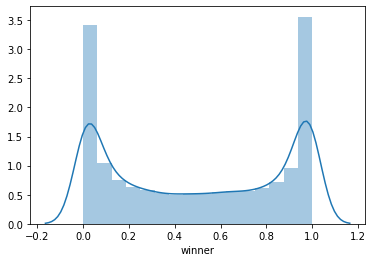

In [434]:
sns.distplot(submission['winner'])

In [435]:
cv

0.7069058564309237

In [436]:
submission.to_csv("../dacon_sc/sub/final_{}.csv".format(cv), index=False)